In [1]:
import os
import json
import sys
import glob

import numpy as np
import pandas as pd

import torch
import torchvision

import matplotlib.pyplot as plt
import lightning as L

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from data_module.data_module import ALDataModule_v1
from model.classifier_model import Classifier1DMaxPoolBNModel, Classifier1D
from utils.model_utils import unwrap_model

from config.optimizer_param_config import optimizer_param_dict
from config.channel_param_config import channel_param_dict


/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import argparse

parser = argparse.ArgumentParser(description="", formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("--train_val_test_limit_data", type=int, default=100,
                    help=f"Used for limit the number of data in train data, -1 mean no limit")

parser.add_argument("-cn", "--class_num", type=int, default=8,
                    help=f"Number of class num use to train")

parser.add_argument("-m", "--model_name", type=str,
                    help=f"Config name of model used for training")

parser.add_argument("-r", "--random_seed", type=int, default=42,
                    help=f"Random Seed")

parser.add_argument("--eval_mode", type=int, default=0,
                    help=f"Eval all models")

if os.path.basename(sys.argv[0]) == 'ipykernel_launcher.py':
    args = parser.parse_args(args=["-m", "4cnnmp_128"])
else:
    args = parser.parse_args()

In [3]:
L.seed_everything(42)

Seed set to 42


42

In [4]:
from lightning.pytorch.utilities.model_summary import ModelSummary

net = Classifier1DMaxPoolBNModel(
    **channel_param_dict[args.model_name],).to("cpu")

model_summary = ModelSummary(net, max_depth=6)
print(model_summary)

   | Name     | Type        | Params | In sizes      | Out sizes    
--------------------------------------------------------------------------
0  | cnn      | Sequential  | 283 K  | [10, 6, 257]  | [10, 256, 1] 
1  | cnn.0    | Conv1d      | 1.8 K  | [10, 6, 257]  | [10, 32, 249]
2  | cnn.1    | MaxPool1d   | 0      | [10, 32, 249] | [10, 32, 83] 
3  | cnn.2    | BatchNorm1d | 64     | [10, 32, 83]  | [10, 32, 83] 
4  | cnn.3    | ReLU        | 0      | [10, 32, 83]  | [10, 32, 83] 
5  | cnn.4    | Conv1d      | 18.5 K | [10, 32, 83]  | [10, 64, 75] 
6  | cnn.5    | MaxPool1d   | 0      | [10, 64, 75]  | [10, 64, 25] 
7  | cnn.6    | BatchNorm1d | 128    | [10, 64, 25]  | [10, 64, 25] 
8  | cnn.7    | ReLU        | 0      | [10, 64, 25]  | [10, 64, 25] 
9  | cnn.8    | Conv1d      | 65.7 K | [10, 64, 25]  | [10, 128, 18]
10 | cnn.9    | MaxPool1d   | 0      | [10, 128, 18] | [10, 128, 6] 
11 | cnn.10   | BatchNorm1d | 256    | [10, 128, 6]  | [10, 128, 6] 
12 | cnn.11   | ReLU        

In [5]:
n_epochs = 2000000
patience = n_epochs//1000

batch_size = 512
optimizer, optimizer_param = optimizer_param_dict["Adam"]
dataset_path = f"dataset/processed_concat_data_{args.class_num}_labels"

log_save_dir = "lightning_logs"
log_save_name = f"10.3_classify/{args.model_name}-{args.class_num}-{args.train_val_test_limit_data}-{args.random_seed}"

In [6]:
data_module = ALDataModule_v1(dataset_path=dataset_path, batch_size=512, prefix="torso_", postfix="_fft")
print("before limit train", np.unique(data_module.train_label, return_counts=True))
print("before limit val", np.unique(data_module.val_label, return_counts=True))
print("before limit test", np.unique(data_module.test_label, return_counts=True))

data_module.limit_and_set_train_val_test_pred_data(
    data_module._train_data,
    data_module._train_label,
    data_module._val_data,
    data_module._val_label,
    data_module._test_data,
    data_module._test_label,
    train_limit_number =args.train_val_test_limit_data,
    val_limit_number=args.train_val_test_limit_data,
    test_limit_number=args.train_val_test_limit_data,
    seed=42)

print("after limit train", np.unique(data_module.train_label, return_counts=True))
print("after limit val", np.unique(data_module.val_label, return_counts=True))
print("after limit test", np.unique(data_module.test_label, return_counts=True))

before limit train (array([], dtype=float64), array([], dtype=int64))
before limit val (array([], dtype=float64), array([], dtype=int64))
before limit test (array([], dtype=float64), array([], dtype=int64))
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
after limit train (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
after limit val (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
after limit test (array([1., 2., 3., 4., 5., 6.

In [7]:
net = Classifier1DMaxPoolBNModel(
    optimizer = optimizer,
    optimizer_param = optimizer_param, 
    **channel_param_dict[args.model_name],
    out_class_num = args.class_num,
)


In [ ]:
print(" ----------------------start training---------------------------")
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger

tensorboard_logger = TensorBoardLogger(save_dir=log_save_dir, name=log_save_name,)
csv_logger = CSVLogger(save_dir=log_save_dir, name=log_save_name,)
checkpoint_callback = ModelCheckpoint(
    dirpath=None,
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    filename="sample_{epoch:02d}-{step:02d}-{val_loss:02f}"
)

trainer = L.Trainer(
    logger=[tensorboard_logger, csv_logger],
    callbacks=[EarlyStopping(monitor="val_loss", patience=patience), checkpoint_callback],
    max_epochs=n_epochs,
    check_val_every_n_epoch=10,
    accelerator="gpu", 
    )

print("np.unique(data_module.train_label, return_counts=True)", np.unique(data_module.train_label, return_counts=True))

trainer.fit(model=net, datamodule=data_module)
trainer_test_dict = trainer.logged_metrics

trainer.test(model=net, datamodule=data_module)
trainer_test_dict.update(trainer.logged_metrics)

print("trainer.logger.log_dir", trainer.logger.log_dir)

for key in trainer_test_dict.keys():
    trainer_test_dict[key] = trainer_test_dict[key].item()

with open(os.path.join(trainer.logger.log_dir, "result.json"), "w") as f:
    json.dump(trainer_test_dict, f, indent=4)

with open(os.path.join(trainer.logger.log_dir, "argparse_params.json"), "w") as f:
    json.dump(args.__dict__, f, indent=4)

In [34]:
if args.eval_mode:
    log_save_dir = "lightning_logs"
    log_save_name = "10.3_classify/{}-{}-{}-{}"
    
    result_save_dict = {}

    for args.model_name in "4cnn_128 4cnn_64".split(" "):
        for args.class_num in [5, 8]:
            for args.train_limit_data in "1000 5000".split(" "):
                for args.random_seed in "42 64".split():
                    
                    save_model_folder = log_save_name.format(args.model_name, args.class_num, args.train_limit_data, args.random_seed)
                    save_model_dir = os.path.join(log_save_dir, save_model_folder)
                    
                    weight = glob.glob(os.path.join(save_model_dir, "version_0", "checkpoints", "*.ckpt"))[0]
                    print(save_model_folder, weight)
    
                    net = Classifier1DMaxPoolBNModel.load_from_checkpoint(weight)
                    data_module = ALDataModule_v1.load_from_checkpoint(weight)
                    data_module.set_normal_train()
    
                    trainer = L.Trainer()
                    trainer.test(model=net, datamodule=data_module, verbose=False)
                    test_acc = trainer.logged_metrics["test_acc"]
                    result_save_dict[save_model_folder] = test_acc


10.1_classify/4cnn_128-5-1000-42 lightning_logs/10.1_classify/4cnn_128-5-1000-42/version_0/checkpoints/sample_epoch=29-step=90-val_loss=0.142611.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 115.91it/s]
10.1_classify/4cnn_128-5-1000-64 lightning_logs/10.1_classify/4cnn_128-5-1000-64/version_0/checkpoints/sample_epoch=29-step=90-val_loss=0.183166.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 114.98it/s]
10.1_classify/4cnn_128-5-5000-42 lightning_logs/10.1_classify/4cnn_128-5-5000-42/version_0/checkpoints/sample_epoch=09-step=130-val_loss=0.137045.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 103.12it/s]
10.1_classify/4cnn_128-5-5000-64 lightning_logs/10.1_classify/4cnn_128-5-5000-64/version_0/checkpoints/sample_epoch=09-step=130-val_loss=0.129845.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 115.04it/s]
10.1_classify/4cnn_128-8-1000-42 lightning_logs/10.1_classify/4cnn_128-8-1000-42/version_0/checkpoints/sample_epoch=109-step=440-val_loss=1.077022.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 131.41it/s]
10.1_classify/4cnn_128-8-1000-64 lightning_logs/10.1_classify/4cnn_128-8-1000-64/version_0/checkpoints/sample_epoch=19-step=80-val_loss=0.522480.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 113.96it/s]
10.1_classify/4cnn_128-8-5000-42 lightning_logs/10.1_classify/4cnn_128-8-5000-42/version_0/checkpoints/sample_epoch=09-step=200-val_loss=0.674701.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 129.75it/s]
10.1_classify/4cnn_128-8-5000-64 lightning_logs/10.1_classify/4cnn_128-8-5000-64/version_0/checkpoints/sample_epoch=19-step=400-val_loss=0.504091.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 104.07it/s]
10.1_classify/4cnn_64-5-1000-42 lightning_logs/10.1_classify/4cnn_64-5-1000-42/version_0/checkpoints/sample_epoch=29-step=90-val_loss=0.148430.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 115.96it/s]
10.1_classify/4cnn_64-5-1000-64 lightning_logs/10.1_classify/4cnn_64-5-1000-64/version_0/checkpoints/sample_epoch=39-step=120-val_loss=0.166433.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 147.54it/s]
10.1_classify/4cnn_64-5-5000-42 lightning_logs/10.1_classify/4cnn_64-5-5000-42/version_0/checkpoints/sample_epoch=09-step=130-val_loss=0.142124.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 113.56it/s]
10.1_classify/4cnn_64-5-5000-64 lightning_logs/10.1_classify/4cnn_64-5-5000-64/version_0/checkpoints/sample_epoch=39-step=520-val_loss=0.136098.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 140.80it/s]
10.1_classify/4cnn_64-8-1000-42 lightning_logs/10.1_classify/4cnn_64-8-1000-42/version_0/checkpoints/sample_epoch=29-step=120-val_loss=0.565843.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 124.45it/s]
10.1_classify/4cnn_64-8-1000-64 lightning_logs/10.1_classify/4cnn_64-8-1000-64/version_0/checkpoints/sample_epoch=19-step=80-val_loss=0.660654.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 115.91it/s]
10.1_classify/4cnn_64-8-5000-42 lightning_logs/10.1_classify/4cnn_64-8-5000-42/version_0/checkpoints/sample_epoch=09-step=200-val_loss=0.655187.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 113.22it/s]
10.1_classify/4cnn_64-8-5000-64 lightning_logs/10.1_classify/4cnn_64-8-5000-64/version_0/checkpoints/sample_epoch=19-step=400-val_loss=0.518996.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 143.14it/s]


In [28]:
if args.eval_mode:
    model_name_list = "4cnn_64 4cnn_128".split(" ")
    args.class_num = 8
    args.train_limit_data = "1000"
    random_list = "42 64".split(" ")
    log_save_name = "10.3_classify/{}-{}-{}-{}"
    
    random_save_dict = {}
    
    for args.random_seed in random_list:
        random_save_dict[args.random_seed] = []
        for args.model_name in model_name_list:
            save_model_folder = log_save_name.format(args.model_name, args.class_num, args.train_limit_data, args.random_seed)
            random_save_dict[args.random_seed].append(result_save_dict[save_model_folder].item())
    
    print(random_save_dict)

{'42': [0.7908247709274292, 0.7821832299232483], '64': [0.7763375043869019, 0.8070911169052124]}


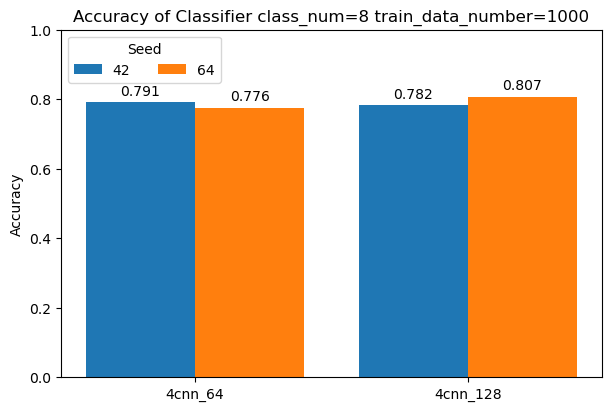

In [29]:
if args.eval_mode:
    fig, ax = plt.subplots(layout='constrained', figsize=(6, 4))
    
    x = np.arange(len(model_name_list))  # the label locations
    width = 0.4  # the width of the bars
    multiplier = 0
    
    for attribute, measurement in random_save_dict.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, list(map(lambda x:round(x, 3), measurement)), width, label=attribute, align="edge")
        ax.bar_label(rects, padding=3)
        multiplier += 1
    
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Accuracy of Classifier class_num={args.class_num} train_data_number={args.train_limit_data}')
    ax.set_xticks(x + width, model_name_list)
    ax.legend(loc='upper left', ncols=3, title="Seed")
    ax.set_ylim(0, 1)

/tmp/ipykernel_133961/60717353.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


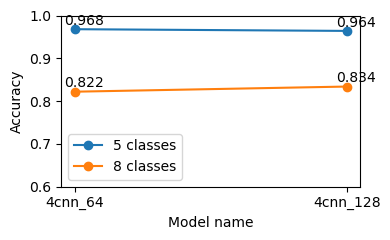

In [68]:
if args.eval_mode:
    fig, ax = plt.subplots(layout='constrained', figsize=(4, 2.5))
    args.random_seed = 64
    args.train_limit_data = "5000"
    
    for args.class_num in [5, 8]:
        x = []
        for args.model_name in "4cnn_64 4cnn_128".split(" "):
            save_model_folder = log_save_name.format(args.model_name, args.class_num, args.train_limit_data, args.random_seed)
            x.append(round(result_save_dict[save_model_folder].item(), 3))

        ax.plot(x, label=f"{args.class_num} classes", marker="o")
        for i, j in enumerate(x):
            ax.annotate(str(j),xy=(i-0.04,j+0.01))
        
    # ax.set_title(f'Accuracy of Classifier class_num={args.class_num} train_data_number={args.train_limit_data}')
    
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Model name')
    
    ax.set_xticks([0, 1], ["4cnn_64", "4cnn_128"])
    ax.set_ylim(0.6, 1)
    
    ax.legend()
    plt.tight_layout()